In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.utils import normalize
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Orthogonal

from sklearn.preprocessing import MinMaxScaler, scale
import matplotlib.pyplot as plt

In [2]:
AAPL = pd.read_csv('../data/transactions/Tech/AAPL.csv')  
GOOG = pd.read_csv('../data/transactions/Tech/GOOG.csv')  
FB = pd.read_csv('../data/transactions/Tech/FB.csv')  
MSFT = pd.read_csv('../data/transactions/Tech/MSFT.csv')  
AMZN = pd.read_csv('../data/transactions/Tech/AMZN.csv') 
ALK = pd.read_csv('../data/transactions/Airline/ALK.csv')  
DAL = pd.read_csv('../data/transactions/Airline/DAL.csv')  
LUV = pd.read_csv('../data/transactions/Airline/LUV.csv')  
RYAAY = pd.read_csv('../data/transactions/Airline/RYAAY.csv')  
SAVE = pd.read_csv('../data/transactions/Airline/SAVE.csv') 
JACK = pd.read_csv('../data/transactions/Fastfood/JACK.csv')  
MCD = pd.read_csv('../data/transactions/Fastfood/MCD.csv')  
TACO = pd.read_csv('../data/transactions/Fastfood/TACO.csv')  
WEN = pd.read_csv('../data/transactions/Fastfood/WEN.csv')  
YUM = pd.read_csv('../data/transactions/Fastfood/YUM.csv') 
GS = pd.read_csv('../data/transactions/Finance/GS.csv')  
JPM = pd.read_csv('../data/transactions/Finance/JPM.csv')  
MER = pd.read_csv('../data/transactions/Finance/MER-PK.csv')  
MS = pd.read_csv('../data/transactions/Finance/MS.csv')  
WFC = pd.read_csv('../data/transactions/Finance/WFC.csv') 
COST = pd.read_csv('../data/transactions/Retailer/COST.csv')  
HD = pd.read_csv('../data/transactions/Retailer/HD.csv')  
KR = pd.read_csv('../data/transactions/Retailer/KR.csv')  
TGT = pd.read_csv('../data/transactions/Retailer/TGT.csv')  
WMT = pd.read_csv('../data/transactions/Retailer/WMT.csv') 

In [3]:
def getStock(stock):
    date = pd.to_datetime(stock["Date"])

    stock = stock.drop(['Date'],axis=1)
    stock= stock.astype('float64')
    #stock['month'] = month = np.array(date.dt.month)
    #stock['day'] = month = np.array(date.dt.day)

    return scale(stock), scale(stock['Close'])

def processData(stock, input_unit,output_unit):
    data,result = getStock(stock)
    X,Y = [],[]
    for i in range(len(data)-input_unit-output_unit):
        X.append(data[i:(i+input_unit)])
        temp = [result[j+i+input_unit] for j in range(output_unit)]
        Y.append(temp)
    return np.array(X),np.array(Y)
time_size = 30
X,y = processData(AAPL,time_size,1)
train_size = int(X.shape[0]*0.80)
X_train,X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train,y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]



In [4]:
model = Sequential() # most common
model.add(LSTM(64, input_shape = (time_size,6), return_sequences=True)) 
model.add(Dropout(0.2))
model.add(LSTM(32, input_shape = (time_size,6), return_sequences=False)) 
model.add(Dropout(0.2))
model.add(Dense(16, kernel_initializer='uniform', activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer='adam', loss='mean_squared_error') 
callback = EarlyStopping(monitor='loss', patience=10,verbose=1,mode='auto')
history = model.fit(X_train,y_train,epochs=300,validation_data=(X_test,y_test),shuffle=False,callbacks=[callback])

Train on 981 samples, validate on 246 samples
Epoch 1/300
981/981 [==============================] - 4s 4ms/step - loss: 0.3586 - val_loss: 2.2457
Epoch 2/300
981/981 [==============================] - 2s 2ms/step - loss: 0.1212 - val_loss: 1.2208
Epoch 3/300
981/981 [==============================] - 2s 2ms/step - loss: 0.0871 - val_loss: 0.9250
Epoch 4/300
981/981 [==============================] - 2s 2ms/step - loss: 0.0538 - val_loss: 0.9698
Epoch 5/300
981/981 [==============================] - 2s 2ms/step - loss: 0.0411 - val_loss: 0.7854
Epoch 6/300
981/981 [==============================] - 2s 2ms/step - loss: 0.0264 - val_loss: 0.8937
Epoch 7/300
981/981 [==============================] - 2s 2ms/step - loss: 0.0365 - val_loss: 0.6811
Epoch 8/300
981/981 [==============================] - 2s 2ms/step - loss: 0.0312 - val_loss: 0.7184
Epoch 9/300
981/981 [==============================] - 2s 2ms/step - loss: 0.0330 - val_loss: 0.5758
Epoch 10/300
981/981 [=======================

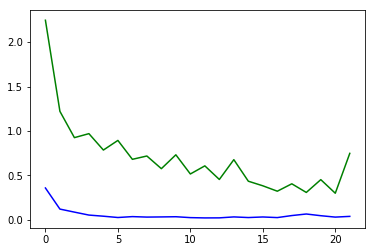

In [5]:
plt.plot(history.history['loss'],color="blue")
plt.plot(history.history['val_loss'],color="green")
plt.show()

In [6]:
def category2(data, threshold):
    top = threshold*(max(data)-min(data))+sum(data)/len(data)
    bottom = -1*threshold*(max(data)-min(data))+sum(data)/len(data)
    print(top,bottom)
    new_data = []
    for item in data:
        if item >= top:
            new_data.append(1)
        elif item < bottom:
            new_data.append(-1)
        else:
            new_data.append(0)
    return new_data
def category(data):
    data[data>=0] = 1
    data[data<0] = -1
    return data
    
def precentage(prediction, real):
    pred = prediction -real
    pred = np.squeeze(prediction, axis=1)
    pred = category(pred)
   
    return pred
def realPrecentage(stock):
    value = pd.Series(stock['Close']-stock['Close'].shift(1), index=stock.index) 
    value = value.bfill() 
    value = np.array(value) 
    val = category(value)
   

    return val
def compare(pred, val):
    #print(pred[:1000])
    #print(val[:1000])
    t = len(pred)
    countTrue = 0
    for i in range(t):
        if pred[i] == val[i]:
            countTrue +=1
    return countTrue/t

In [7]:
testdata = []
testdata.append(ALK)
testdata.append(DAL)
testdata.append(RYAAY)
testdata.append(SAVE)
testdata.append(JACK)
testdata.append(TACO)
testdata.append(WEN)
testdata.append(GS)
testdata.append(JPM)
testdata.append(MER)
testdata.append(MS)
testdata.append(WFC)
testdata.append(COST)
testdata.append(HD)
testdata.append(KR)
testdata.append(TGT)
testdata.append(WMT)

In [8]:
for stockdata in testdata:
    inputg,outputg = processData(stockdata,time_size,1)
    prediction = model.predict(inputg)
    pred = precentage(prediction, outputg)
    val = realPrecentage(stockdata)
    print(compare(pred, val))


0.4963325183374083
0.5240423797881011
0.5069274653626732
0.5158924205378973
0.4906275468622657
0.4954545454545455
0.508557457212714
0.49551752241238795
0.4938875305623472
0.5004074979625102
0.4898125509372453
0.5020374898125509
0.541157294213529
0.4971475142624287
0.4718826405867971
0.5240423797881011
0.537082314588427
